# Create merged table with all labelled texts from several files of texts with label

## Ordinary imports

In [2]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [3]:
# Settings for charts to increase fonts and sizes.
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

plt.rcParams['axes.axisbelow'] = True

## Import custom function to collect news and prices, work with file system and modelling

In [4]:
import trade_news_predict_prices

# Some constants (path, random seeed, api key)

In [10]:
general_constants = pd.read_csv('general_constants.txt', sep=',', delimiter = ",", header='infer', index_col='variable_name')
general_constants

,value
variable_name,
random_seed,420
directory_path,C:/DAN/t_systems/trade_news
folder_name_headlines,data/backup_headlines/
folder_name_logger,data/logger/
folder_name_merged_news_and_prices,data/merged_news_and_prices/
folder_name_for_labelling,data/for_labelling/
folder_name_for_labeled_news_iter1,data/labeled_news_iter1/
set_app_key1,ccebd1ff788d4574818be93e35c4741925ac214e
set_app_key2,a8be043d709946238759b0c5cb34c8f90d4e6f2c


In [11]:
# Path to folder with directory is a constant value that stores in .txt
# You can change them in some_constants.txt file or define them on your own.
directory_path = str(general_constants.loc['directory_path'][0])
random_seed = int(general_constants.loc['random_seed'][0])
print(random_seed)
print(directory_path)

420
C:/DAN/t_systems/trade_news


# Read several files with labels and merge them

In [5]:
# Only labelling columns are selected
cols_of_labelling = [
#     'Unnamed: 0',
#     'storyId',
#     'versionCreated',
#     'sourceCode',
#     'ric',
#     'story_lang',
#     'Analyst_Rating',
#     'Asset_Sale',
#     'Collaboration',
#     'Contract_-_Agreement_-_Deal',
#     'Credit_Debt_Rating',
#     'Dividend',
#     'Eco_Issues',
#     'Executive_Change',
#     'Financial_Results',
#     'Investigation',
#     'Investment',
#     'Lawsuit',
#     'Merger_and_Acquisition',
#     'Price_Target',
#     'Product_Update',
#     'Security_Protection',
#     'Settlement',
#     'Stock_Buyback',
#     'Workforce_Change',
#     'number_of_types_detected',
#     'headline',
#     'story_wo_html',
    'my_label_Analyst_Rating',
#    'my_label_Asset_Sale',
    'my_label_Collaboration',
    'my_label_Contract_-_Agreement_-_Deal',
    'my_label_Credit_Debt_Rating',
    'my_label_Dividend',
    'my_label_Eco_Issues',
    'my_label_Executive_Change',
    'my_label_Financial_Results',
    'my_label_Investigation',
    'my_label_Investment',
    'my_label_Lawsuit',
#    'my_label_Merger_and_Acquisition',
    'my_label_Price_Target',
    'my_label_Product_Update',
    'my_label_Security_Protection',
    'my_label_Settlement',
    'my_label_Stock_Buyback',
    'my_label_Workforce_Change',
#     'my_label_digest'
]

len(cols_of_labelling)

17

In [13]:
# Create list of paths to files with labels to iterate them 
import re
from trade_news_predict_prices import get_files_name_in_folder
regex_for_filter = re.compile(r'/for_labelling(.*).xlsx')

files_list_labelling = list(filter(
    regex_for_filter.search, 
    get_files_name_in_folder(
        folder_name=general_constants.loc['folder_name_for_labeled_news_iter1'][0])
))

len(files_list_labelling)

20

In [14]:
labelling_all_df = pd.DataFrame(data = [], columns=[])

for file_name_now in files_list_labelling:
    # Earlier we have already created a list of files with full paths, let's iterate over it
    labelled_slice_now = pd.read_excel(file_name_now)

    # Select only columns with labels and news ID
    try:
        # Let's try to load the 'my_label_digest' column
        # It means that the text contains several different news at once
        labelled_slice_now = labelled_slice_now[
            ['storyId'] + cols_of_labelling + ['my_label_digest']
        ]
    except Exception as e:
        # If it didn't work, try without this column
        # print (e, end = '')
        labelled_slice_now = labelled_slice_now[
            ['storyId'] + cols_of_labelling
        ]        

    # Replace the blanks with zeros. Zero - news is not about this type of event
    labelled_slice_now = labelled_slice_now
    labelled_slice_now['labels_sum'] = labelled_slice_now.sum(axis=1)
    labelled_slice_now = labelled_slice_now[labelled_slice_now['labels_sum'] > 0].reset_index(drop=True)

    print(labelled_slice_now.shape[0], end=' ')
    
    labelling_all_df = labelling_all_df.append(labelled_slice_now, ignore_index = True)
    
    print(labelling_all_df.shape[0], end=' ')
    
    print(file_name_now)

labelling_all_df = labelling_all_df.replace(np.nan, 0)
labelling_all_df = labelling_all_df.drop(columns=['labels_sum'])

# Replace all twos and ones with ones, leaving only two possible labels
labelling_all_df = labelling_all_df.replace(2, 1)
labelling_all_df = labelling_all_df.replace(1, 1)
labelling_all_df = labelling_all_df.replace(0, 0)

1 1 data/labeled_news_iter1/for_labelling2_Merger_and_Acquisition.xlsx
100 101 data/labeled_news_iter1/for_labelling_Analyst_Rating.xlsx
0 101 data/labeled_news_iter1/for_labelling_Asset_Sale.xlsx
43 144 data/labeled_news_iter1/for_labelling_Collaboration.xlsx
51 195 data/labeled_news_iter1/for_labelling_Contract_-_Agreement_-_Deal.xlsx
22 217 data/labeled_news_iter1/for_labelling_Credit_Debt_Rating.xlsx
64 281 data/labeled_news_iter1/for_labelling_Dividend.xlsx
44 325 data/labeled_news_iter1/for_labelling_Eco_Issues.xlsx
37 362 data/labeled_news_iter1/for_labelling_Executive_Change.xlsx
80 442 data/labeled_news_iter1/for_labelling_Financial_Results.xlsx
64 506 data/labeled_news_iter1/for_labelling_Investigation.xlsx
28 534 data/labeled_news_iter1/for_labelling_Investment.xlsx
42 576 data/labeled_news_iter1/for_labelling_Lawsuit.xlsx
3 579 data/labeled_news_iter1/for_labelling_Merger_and_Acquisition.xlsx
52 631 data/labeled_news_iter1/for_labelling_Price_Target.xlsx
35 666 data/labeled

918.0


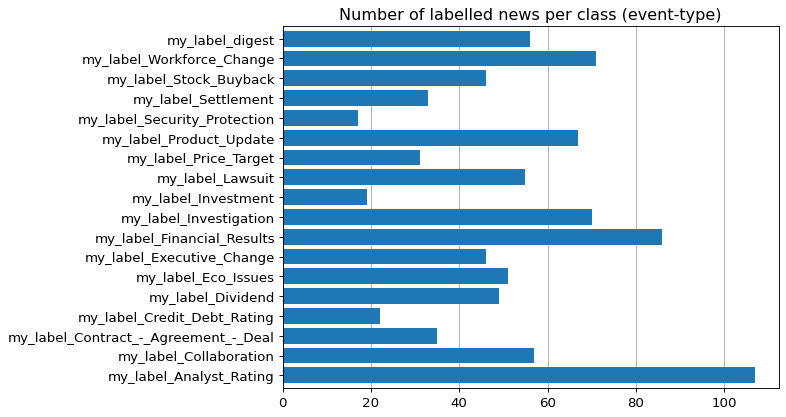

In [16]:
print(
    labelling_all_df[cols_of_labelling + ['my_label_digest']].sum().sum()
)
(labelling_all_df[cols_of_labelling + ['my_label_digest']].sum()).plot(kind='barh', width=0.8, figsize=(8,6))
plt.title('Number of labelled news per class (event-type)')
plt.grid(True, axis='x')
plt.savefig('exhibits_saved/' + 'Number of labelled news per class (event-type).png', bbox_inches = "tight")

In [17]:
labelling_all_df['list_label'] = labelling_all_df[cols_of_labelling + ['my_label_digest']].values.tolist()
labelling_all_df.tail(1)

,storyId,my_label_Analyst_Rating,my_label_Collaboration,my_label_Contract_-_Agreement_-_Deal,my_label_Credit_Debt_Rating,my_label_Dividend,my_label_Eco_Issues,my_label_Executive_Change,my_label_Financial_Results,my_label_Investigation,my_label_Investment,my_label_Lawsuit,my_label_Price_Target,my_label_Product_Update,my_label_Security_Protection,my_label_Settlement,my_label_Stock_Buyback,my_label_Workforce_Change,my_label_digest,list_label
850,urn:newsml:reuters.com:20191209:nNRAaepw3s:1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
labelling_all_df.sum()

storyId                                 urn:newsml:reuters.com:20201022:nNDL3RTZ1L:1ur...
my_label_Analyst_Rating                                                               107
my_label_Collaboration                                                                 57
my_label_Contract_-_Agreement_-_Deal                                                   35
my_label_Credit_Debt_Rating                                                            22
my_label_Dividend                                                                      49
my_label_Eco_Issues                                                                    51
my_label_Executive_Change                                                              46
my_label_Financial_Results                                                             86
my_label_Investigation                                                                 70
my_label_Investment                                                                    19
my_label_L

In [20]:
file_path = 'data/' + 'labelling_all_df' + '.csv'
labelling_all_df.to_csv(file_path, index=False)

In [21]:
labelling_all_df.columns

Index(['storyId', 'my_label_Analyst_Rating', 'my_label_Collaboration',
       'my_label_Contract_-_Agreement_-_Deal', 'my_label_Credit_Debt_Rating',
       'my_label_Dividend', 'my_label_Eco_Issues', 'my_label_Executive_Change',
       'my_label_Financial_Results', 'my_label_Investigation',
       'my_label_Investment', 'my_label_Lawsuit', 'my_label_Price_Target',
       'my_label_Product_Update', 'my_label_Security_Protection',
       'my_label_Settlement', 'my_label_Stock_Buyback',
       'my_label_Workforce_Change', 'my_label_digest', 'list_label'],
      dtype='object')

# Save texts with expert's labels

In [23]:
# Read the computed early file detected expert key words
key_words_detection_df = pd.read_csv('data/' + "key_words_detection_df.csv")
print(key_words_detection_df.shape)

(399141, 109)


In [24]:
# Add texts to our dataset with labels
lower_labelled_texts_list_types = pd.merge(
    key_words_detection_df, 
    labelling_all_df[['storyId', 'list_label']], 
    how="right", 
    on='storyId'
).drop_duplicates(
    subset=['storyId'], 
    keep='first'
).reset_index(drop=True) # [['story_wo_html', 'list_label']]

lower_labelled_texts_list_types['story_wo_html_lower'] = lower_labelled_texts_list_types['story_wo_html'].str.lower()
lower_labelled_texts_list_types = lower_labelled_texts_list_types.drop(columns=['story_wo_html'])

lower_labelled_texts_list_types = lower_labelled_texts_list_types[['story_wo_html_lower', 'list_label']]

In [25]:
# We can choose an event type for lower_labelled_texts_one_type
# But lower_labelled_texts_list_types has info about all event types
lower_labelled_texts_one_type = pd.merge(
    key_words_detection_df, 
    labelling_all_df[['storyId', 'my_label_Executive_Change']], 
    how="right", 
    on='storyId'
).drop_duplicates(
    subset=['storyId'], 
    keep='first'
).reset_index(drop=True)[['story_wo_html', 'my_label_Executive_Change']]

lower_labelled_texts_one_type['story_wo_html_lower'] = lower_labelled_texts_one_type['story_wo_html'].str.lower()
lower_labelled_texts_one_type = lower_labelled_texts_one_type.drop(columns=['story_wo_html'])

lower_labelled_texts_one_type = lower_labelled_texts_one_type[['story_wo_html_lower', 'my_label_Executive_Change']]

In [26]:
print(
    'Number of labels:',
    len(lower_labelled_texts_list_types['list_label'][1])
)

Number of labels: 18


In [27]:
df = lower_labelled_texts_list_types['list_label'].apply(pd.Series)

df['story_wo_html_lower'] = lower_labelled_texts_list_types['story_wo_html_lower']
list(df.sum()[:len(cols_of_labelling) + 1])

[97.0,
 52.0,
 29.0,
 20.0,
 46.0,
 47.0,
 43.0,
 82.0,
 62.0,
 18.0,
 46.0,
 26.0,
 66.0,
 17.0,
 28.0,
 42.0,
 68.0,
 22.0]

In [28]:
lower_labelled_texts_list_types.to_csv('data/' + 'lower_labelled_texts_list_types.csv')
lower_labelled_texts_one_type.to_csv('data/' + 'lower_labelled_texts_one_type.csv')